In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import theano.tensor as tt

In [2]:
import pickle
with open('cache_dict_float32','rb') as f:
    cache_dict_float32 = pickle.load(f)

In [3]:
cache_dict_float32.keys()

dict_keys(['time_length_list', 'latent_scen_4_meansd', 'stage_list_float32'])

In [4]:
stage_list = cache_dict_float32['stage_list_float32']
time_length_list = cache_dict_float32['time_length_list']
latent_scen_4_meansd = cache_dict_float32['latent_scen_4_meansd']

In [5]:
stage_list[0].dtype

dtype('float32')

开始试图单独推断一个stage的内容来做一个初步的优化，实在不行再子采样，变分推断或者强行分成四个变量估计再合并起来，
这些没有理论正确性的方法还是越少用越好。

先尝试处理stage1

In [6]:
stage = stage_list[0]

In [7]:
%%time
import pymc3 as pm
from pymc3 import Normal,Poisson,Deterministic
from pymc3.math import switch,where

Wall time: 8.59 s


In [9]:
model = pm.Model()

In [10]:
stage.shape

(202, 4, 193)

In [19]:
meansd = np.array(latent_scen_4_meansd[0],dtype='float32')
time_length = np.array(time_length_list[0],dtype='float32')

In [12]:
meansd.shape

(5, 5, 2)

In [13]:
meansd[:,:,0]

array([[  2.18402843e+01,   3.54579203e-02,   4.56683151e-02,
          1.89574936e+02,   1.26586617e+02],
       [  1.14839106e+01,   1.48279705e+01,   7.30198026e-02,
          1.74373138e+02,   1.38980789e+02],
       [  4.33452721e+01,   1.13629663e+00,   1.68316826e-01,
          8.65855789e+01,   9.01471710e+01],
       [  1.76967831e+01,   2.27722764e+00,   5.69306947e-02,
          5.34375000e+01,   9.23385925e+01],
       [  4.13647985e+00,   2.19358146e-01,   1.69853196e-02,
          8.93790531e+00,   3.92387962e+01]], dtype=float32)

In [14]:
period_num = meansd.shape[0] # in stage 1, 5
var_num = meansd.shape[1] # always 5

In [15]:
%%time
with model:
    # 这里要设定5个参数 'shift_lam','ctrl_lam','x_lam','move_mean','move_sd' 的正态分布，在stage 1里有五个阶段
    param5 = Normal('param5',mu = meansd[:,:,0],sd = meansd[:,:,1], shape=(period_num, var_num))

Wall time: 33.4 s


In [16]:
np.triu(np.ones((4,4),dtype='float32')).T

array([[ 1.,  0.,  0.,  0.],
       [ 1.,  1.,  0.,  0.],
       [ 1.,  1.,  1.,  0.],
       [ 1.,  1.,  1.,  1.]], dtype=float32)

In [20]:
durations_num = time_length.shape[0]
assert time_length.shape[0] == period_num - 1
replay_num = stage.shape[0]

cumsum_mat = np.triu(np.ones((durations_num, durations_num),dtype='float32')).T

In [21]:
%%time
with model:
    # 这里设定stage 1 里5个阶段对应的前4个阶段的持续时间，然后定义断点为持续时间的函数
    # 虽然这个变量不应该是伪随机变量或随机参数，而是隐变量，所以每个replay应该对应一个向量实现，这是第一次用上replay数量信息（之前就搞错了。。）
    durations = Normal('durations', mu = time_length[:,0], sd = time_length[:,1], shape = (replay_num, durations_num))
    #breaks = pm.math.dot(cumsum_mat, durations) # 使用矩阵技巧不用那个脑残的列表构造
    breaks = tt.cumsum(durations, axis=1) # 202 * 4 matrix 
    Deterministic('breaks', breaks)
    

Wall time: 557 ms


In [22]:
model.free_RVs

[param5, durations]

In [23]:
stage_length = stage.shape[2]
time_axis = np.arange(stage_length)

#_time_axis = np.tile(time_axis,(durations_num,1)) # tile matrix trick to apply elementwise logic computing. wtf, I want boardcas

In [24]:
_time_axis = np.tile(time_axis,(replay_num,durations_num,1)) # add batch...
_time_axis.shape

(202, 4, 193)

In [25]:
np.tile(np.empty((202,4)),(stage_length, 1,1)).shape 
# it copy the (202,4) matrix 193 times into the new first axis,we need transpose it for our purpose

(193, 202, 4)

In [26]:
np.transpose(np.tile(np.empty((202,4)),(stage_length, 1,1)),[1,2,0]).shape
# well, it exactly is we want.

(202, 4, 193)

In [27]:
%%time
with model:
    # 这里定义出193个时间步到底属于哪个类，这是个大坑，之前居然没想到where(x > y,1,0)之类的方法把逻辑值转成01真是脑残了。。
    _breaks = tt.transpose(tt.tile(breaks,(stage_length, 1, 1)),[1,2,0]) # 高维转置。。看的都头大，和单向量情况还不一样，醉了。。
    _mask =  pm.math.where(_time_axis > _breaks, 1, 0) # 这里之前貌似写错了，会不会就是这个引发了错误？
    index = pm.Deterministic('index', tt.sum(_mask, axis=1)) # 202 * 193 matrix

Wall time: 1.36 s


In [28]:
%%time
with model:
    # 最终定义4个可观测变量如何和前面那坨东西联系起来
    '''
    _param = param5[index] 
    # _param is 202 * 193 * 5 array, param5 is 5 x 5 matrix ( 5 for period * 5 for var_num), index is 202 * 193 matrix (202 for obs 193 for stage length)
    well, I can't find a vector way to do it, so I can only resort the ugly circle...
    '''
    '''
    _param = tt.zeros((replay_num, stage_length, var_num))
    for i in range(replay_num):
        _param[i,:,:] = _param = param5[index[i]]
    # This way will raise `TypeError: 'TensorVariable' object does not support item assignment`
    '''
    _param_list = []
    for i in range(replay_num):
        _param_list.append(param5[index[i]])
    _param = pm.math.stack(_param_list) # 202 * 193 * 5 array
    pressing_shift = Poisson('pressing_shift', mu = _param[:,:,0], observed = stage[:,0,:]) # 202 * 193 matrix
    pressing_ctrl = Poisson('pressing_ctrl', mu = _param[:,:,1], observed = stage[:,1,:])
    pressing_x = Poisson('pressing_x', mu = _param[:,:,2], observed = stage[:,2,:])
    move = Normal('move', mu = _param[:,:,3], sd = _param[:,:,4], observed = stage[:,3,:])

Wall time: 3.02 s


It's the time cooling your fucker brain..这时候程序占用170MB内存。包括这些库啊，部分数据啊

In [29]:
%%time
with model:
    step = pm.Metropolis()
    trace = pm.sample(100, tune=0, init=None, step=step)

100%|████████████████████████████████████████| 100/100 [00:04<00:00, 21.67it/s]


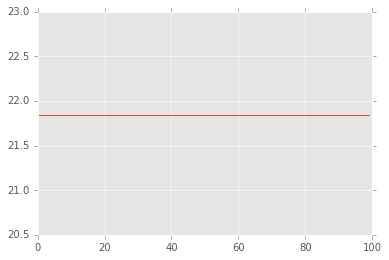

In [30]:
plt.plot(trace['param5'][:,0,0])

In [33]:
pm.variational.

In [132]:
# Go on!
with model:
    trace = pm.sample(100)

100%|████████████████████████████████████████| 100/100 [00:03<00:00, 27.30it/s]


In [145]:
trace.varnames

['param5', 'durations', 'breaks', 'index']

In [164]:
trace['param5'].shape

(100, 5, 5)

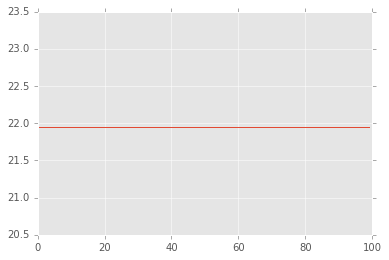

In [165]:
plt.plot(trace['param5'][:,0,0])

In [167]:
np.all(trace['param5'] == trace['param5'][0,:,:])

True

所以这些数一次都没有变过？。。。你TM逗我。看来模型又失败了。

In [168]:
with model:
    trace2 = pm.sample(1000)

100%|██████████████████████████████████████| 1000/1000 [00:35<00:00, 28.96it/s]


In [169]:
trace

<MultiTrace: 1 chains, 100 iterations, 4 variables>

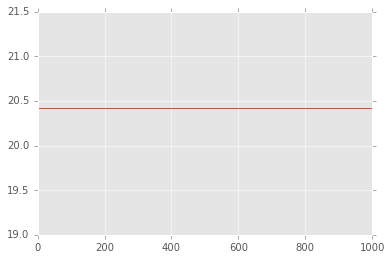

In [170]:
plt.plot(trace2['param5'][:,0,0])

In [171]:
with model:
    step = pm.NUTS()
    trace3 = pm.sample(100, tune=100, init=None, step=step)

  4%|█▋                                        | 4/100 [00:03<01:30,  1.07it/s]

In [173]:
trace3['param5']

array([[[  2.18452394e+01,   3.59241068e-02,   4.57795319e-02,
           1.89682486e+02,   1.26686150e+02],
        [  1.14993603e+01,   1.48320810e+01,   7.24547199e-02,
           1.74163126e+02,   1.38437670e+02],
        [  4.33551722e+01,   1.13648908e+00,   1.68625883e-01,
           8.66741252e+01,   9.00956491e+01],
        [  1.76703744e+01,   2.26880914e+00,   5.62836635e-02,
           5.33651224e+01,   9.23733133e+01],
        [  4.13537874e+00,   2.19682089e-01,   1.69997539e-02,
           9.05428685e+00,   3.92462798e+01]],

       [[  2.18452394e+01,   3.59241068e-02,   4.57795319e-02,
           1.89682486e+02,   1.26686150e+02],
        [  1.14993603e+01,   1.48320810e+01,   7.24547199e-02,
           1.74163126e+02,   1.38437670e+02],
        [  4.33551722e+01,   1.13648908e+00,   1.68625883e-01,
           8.66741252e+01,   9.00956491e+01],
        [  1.76703744e+01,   2.26880914e+00,   5.62836635e-02,
           5.33651224e+01,   9.23733133e+01],
        [  4.1353